In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = Path("..").resolve()
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"

scored_path = PROCESSED_DIR / "fourth_down_scored.parquet"
if not scored_path.exists():
    raise FileNotFoundError("Missing fourth_down_scored.parquet. Run Notebook 03 first.")

df = pd.read_parquet(scored_path)
print("Loaded:", scored_path, df.shape)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

TEAM = "MIA"
df.head()

Loaded: /Users/klevy/Documents/fourth_down/data/processed/fourth_down_scored.parquet (13041, 26)


,season,week,game_id,play_id,posteam,defteam,home_team,away_team,qtr,game_seconds_remaining,ydstogo,yardline_100,kick_distance,decision,decision_simple,best_option,p_convert,p_fg_make,p_posteam_win_base,p_posteam_win_go,p_posteam_win_punt,p_posteam_win_fg,p_actual,p_best,decision_cost,desc
0,2022,1,2022_01_BAL_NYJ,172.0,NYJ,BAL,NYJ,BAL,1.0,3533.0,15.0,64.0,81.0,punt,punt,fg,NaN,NaN,4.383149e-17,4.163919e-17,3.693949e-17,3.404855e-14,3.693949e-17,3.404855e-14,3.401161e-14,"(13:53) 7-B.Mann punts 45 yards to BAL 19, Cen..."
1,2022,1,2022_01_BAL_NYJ,368.0,BAL,NYJ,NYJ,BAL,1.0,3296.0,1.0,51.0,68.0,punt,punt,go,NaN,NaN,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,"(9:56) 11-J.Stout punts 40 yards to NYJ 11, Ce..."
2,2022,1,2022_01_BAL_NYJ,533.0,NYJ,BAL,NYJ,BAL,1.0,3132.0,9.0,82.0,99.0,punt,punt,fg,NaN,NaN,4.427072e-17,4.531374e-17,4.224172e-17,3.730114e-14,4.224172e-17,3.730114e-14,3.725890e-14,"(7:12) 7-B.Mann punts 48 yards to BAL 34, Cent..."
3,2022,1,2022_01_BAL_NYJ,617.0,BAL,NYJ,NYJ,BAL,1.0,3068.0,9.0,65.0,82.0,punt,punt,go,NaN,NaN,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,"(6:08) 11-J.Stout punts 48 yards to NYJ 17, Ce..."
4,2022,1,2022_01_BAL_NYJ,790.0,BAL,NYJ,NYJ,BAL,1.0,2899.0,3.0,6.0,23.0,field_goal,fg,go,NaN,0.973675,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,"(3:19) 9-J.Tucker 24 yard field goal is GOOD, ..."


In [2]:
# Ensure expected columns exist
required = ["posteam","decision_simple","best_option","decision_cost","ydstogo","yardline_100","season","week"]
missing = [c for c in required if c not in df.columns]
print("Missing required columns:", missing)

df = df.copy()
df["decision_cost"] = pd.to_numeric(df["decision_cost"], errors="coerce")

# Keep only rows with modeled options
df_valid = df[df["decision_simple"].isin(["go","punt","fg"])].copy()
print("Valid rows:", df_valid.shape)

mia = df_valid[df_valid["posteam"] == TEAM].copy()
print("MIA rows:", mia.shape)

mia[["season","week","decision_simple","best_option","decision_cost","ydstogo","yardline_100"]].head()

Missing required columns: []
Valid rows: (12301, 26)
MIA rows: (367, 26)


,season,week,decision_simple,best_option,decision_cost,ydstogo,yardline_100
129,2022,1,fg,fg,0.000000e+00,13.0,25.0
131,2022,1,punt,fg,5.551115e-15,4.0,49.0
133,2022,1,go,fg,3.996803e-15,7.0,42.0
134,2022,1,punt,fg,6.550316e-15,2.0,66.0
136,2022,1,fg,fg,0.000000e+00,5.0,31.0


In [3]:
agg = (
    df_valid
    .assign(is_go=lambda d: (d["decision_simple"] == "go").astype(int))
    .groupby(["season","posteam"], as_index=False)["is_go"].mean()
    .rename(columns={"is_go":"go_rate"})
)

league = agg.groupby("season", as_index=False)["go_rate"].mean().rename(columns={"go_rate":"league_go_rate"})
mia_go = agg[agg["posteam"] == TEAM].merge(league, on="season", how="left")

mia_go

,season,posteam,go_rate,league_go_rate
0,2022,MIA,0.203125,0.188691
1,2023,MIA,0.271930,0.198352
2,2024,MIA,0.248000,0.202835


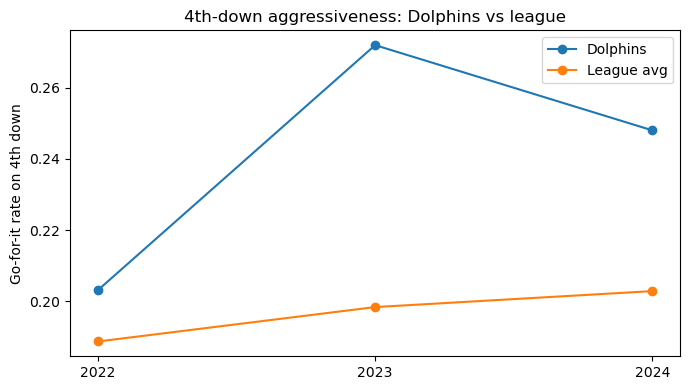

In [4]:
plt.figure(figsize=(7,4))
plt.plot(mia_go["season"].astype(str), mia_go["go_rate"], marker="o", label="Dolphins")
plt.plot(mia_go["season"].astype(str), mia_go["league_go_rate"], marker="o", label="League avg")
plt.ylabel("Go-for-it rate on 4th down")
plt.title("4th-down aggressiveness: Dolphins vs league")
plt.legend()
plt.tight_layout()
plt.show()

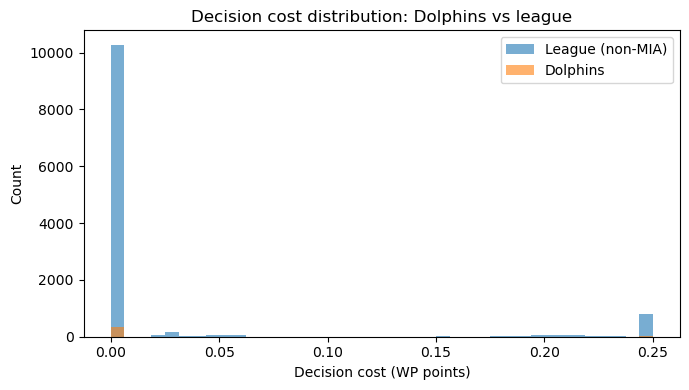

count    3.670000e+02
mean     2.059166e-02
std      6.854536e-02
min      0.000000e+00
50%      8.311672e-21
75%      2.303791e-06
90%      4.356880e-03
95%      2.500000e-01
max      2.500000e-01
Name: decision_cost, dtype: float64

In [5]:
mia_cost = mia["decision_cost"].dropna().clip(0, 0.25)
lg_cost  = df_valid[df_valid["posteam"] != TEAM]["decision_cost"].dropna().clip(0, 0.25)

plt.figure(figsize=(7,4))
plt.hist(lg_cost, bins=40, alpha=0.6, label="League (non-MIA)")
plt.hist(mia_cost, bins=40, alpha=0.6, label="Dolphins")
plt.xlabel("Decision cost (WP points)")
plt.ylabel("Count")
plt.title("Decision cost distribution: Dolphins vs league")
plt.legend()
plt.tight_layout()
plt.show()

mia_cost.describe(percentiles=[0.5, 0.75, 0.9, 0.95])

In [6]:
mia = mia.copy()
mia["differs_from_best"] = mia["decision_simple"] != mia["best_option"]

diff_rate = mia["differs_from_best"].mean()
avg_cost_when_diff = mia.loc[mia["differs_from_best"], "decision_cost"].mean()
median_cost_when_diff = mia.loc[mia["differs_from_best"], "decision_cost"].median()

print("Share of Dolphins 4th downs differing from model-best:", round(diff_rate, 3))
print("Avg decision cost when differing:", round(avg_cost_when_diff, 4))
print("Median decision cost when differing:", round(median_cost_when_diff, 4))

Share of Dolphins 4th downs differing from model-best: 0.708
Avg decision cost when differing: 0.044
Median decision cost when differing: 0.0


In [7]:
cols = [
    "season","week","game_id","play_id","qtr","game_seconds_remaining",
    "ydstogo","yardline_100",
    "decision_simple","best_option","decision_cost",
    "p_posteam_win_go","p_posteam_win_punt","p_posteam_win_fg",
    "desc"
]
cols = [c for c in cols if c in mia.columns]

top = mia.sort_values("decision_cost", ascending=False).head(20)[cols]
top

,season,week,game_id,play_id,qtr,game_seconds_remaining,ydstogo,yardline_100,decision_simple,best_option,decision_cost,p_posteam_win_go,p_posteam_win_punt,p_posteam_win_fg,desc
7587,2023,14,2023_14_TEN_MIA,3844.0,4.0,376.0,15.0,58.0,punt,fg,0.474623,0.049069,0.043467,0.518090,"(6:16) 16-J.Bailey punts 47 yards to TEN 11, C..."
7588,2023,14,2023_14_TEN_MIA,4480.0,4.0,144.0,2.0,67.0,punt,fg,0.473715,0.051062,0.046614,0.520329,"(2:24) 16-J.Bailey punts 45 yards to TEN 22, C..."
10390,2024,8,2024_08_ARI_MIA,3882.0,4.0,308.0,9.0,47.0,punt,fg,0.472187,0.056236,0.049689,0.521876,"(5:08) 16-J.Bailey punts 36 yards to ARI 11, C..."
7577,2023,14,2023_14_TEN_MIA,968.0,2.0,2655.0,7.0,42.0,punt,fg,0.471308,0.058359,0.051516,0.522824,"(14:15) 16-J.Bailey punts 33 yards to TEN 9, C..."
7580,2023,14,2023_14_TEN_MIA,1885.0,2.0,1838.0,7.0,66.0,punt,fg,0.470731,0.060627,0.055073,0.525804,"(:38) 16-J.Bailey punts 56 yards to TEN 10, Ce..."
10385,2024,8,2024_08_ARI_MIA,1316.0,2.0,2357.0,8.0,56.0,punt,fg,0.470279,0.062262,0.055704,0.525983,"(9:17) 16-J.Bailey punts 56 yards to end zone,..."
7583,2023,14,2023_14_TEN_MIA,2780.0,3.0,1260.0,4.0,85.0,punt,fg,0.469825,0.059683,0.056872,0.526697,"(6:00) 16-J.Bailey punts 50 yards to TEN 35, C..."
3795,2022,17,2022_17_MIA_NE,3559.0,4.0,211.0,16.0,74.0,go,fg,0.469642,0.008994,0.009931,0.478636,(3:31) (Shotgun) 19-S.Thompson pass short left...
7589,2023,14,2023_14_TEN_MIA,4877.0,4.0,26.0,2.0,55.0,go,fg,0.469120,0.049257,0.044139,0.518378,"(:26) (No Huddle, Shotgun) 1-T.Tagovailoa sack..."
3794,2022,17,2022_17_MIA_NE,3116.0,4.0,591.0,4.0,58.0,punt,fg,0.468895,0.009752,0.010345,0.479240,"(9:51) 4-T.Morstead punts 47 yards to NE 11, C..."


/var/folders/l0/jdg4bp7x7n7_9s355c6l3bqc0000gn/T/ipykernel_66673/33382317.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zones.groupby(["ytg_bin","yl_bin"])["best_option"]


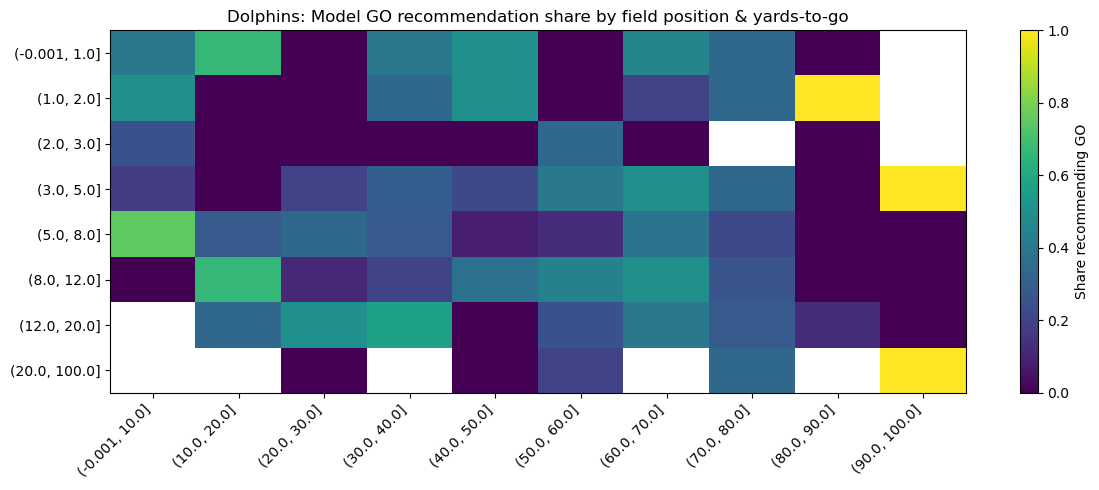

In [8]:
zones = mia.dropna(subset=["ydstogo","yardline_100"]).copy()
zones["yl_bin"] = pd.cut(zones["yardline_100"], bins=np.arange(0, 105, 10), include_lowest=True)
zones["ytg_bin"] = pd.cut(zones["ydstogo"], bins=[0,1,2,3,5,8,12,20,100], include_lowest=True)

go_share = (
    zones.groupby(["ytg_bin","yl_bin"])["best_option"]
    .apply(lambda s: (s == "go").mean())
    .unstack()
)

plt.figure(figsize=(12,5))
plt.imshow(go_share.values, aspect="auto")
plt.xticks(range(go_share.shape[1]), [str(c) for c in go_share.columns], rotation=45, ha="right")
plt.yticks(range(go_share.shape[0]), [str(i) for i in go_share.index])
plt.colorbar(label="Share recommending GO")
plt.title("Dolphins: Model GO recommendation share by field position & yards-to-go")
plt.tight_layout()
plt.show()

In [9]:
# Quick narrative summary you can paste into README / email
summary = f"""
### Miami Dolphins 4th-Down Decision Case Study

- Dolphins go-for-it rate vs league: {mia_go["go_rate"].mean():.3f} (league avg {mia_go["league_go_rate"].mean():.3f}) across seasons in this sample.
- When Dolphins differ from the model’s best option: {diff_rate:.3f} of 4th-down decisions.
- Average win-probability decision cost when differing: {avg_cost_when_diff:.4f} WP.

Interpretation:
Most 4th-down choices are low-cost, but a small number of situations drive most of the lost WP.
The table of top costly plays provides concrete examples to review with coaching/strategy staff.
""".strip()

print(summary)

### Miami Dolphins 4th-Down Decision Case Study

- Dolphins go-for-it rate vs league: 0.241 (league avg 0.197) across seasons in this sample.
- When Dolphins differ from the model’s best option: 0.708 of 4th-down decisions.
- Average win-probability decision cost when differing: 0.0440 WP.

Interpretation:
Most 4th-down choices are low-cost, but a small number of situations drive most of the lost WP.
The table of top costly plays provides concrete examples to review with coaching/strategy staff.
